In [0]:
!mount -t tmpfs tmpfs -o size=12G /tmp

In [0]:
!pip install PyDrive

    100% |████████████████████████████████| 993kB 19.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [0]:
def Init_PyDrive():
  global ID_BY_NAME
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials

  auth.authenticate_user()
  global gauth
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  global drive
  drive = GoogleDrive(gauth)
  ID_BY_NAME = dict()
  file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
  for i in file_list:
    print(i['title'])
    ID_BY_NAME[i['title']] = i['id']

In [0]:
Init_PyDrive()

gender3.h5
gender2.h5
fer2013.csv
meta_postprocessed.csv
triples1.h5
triples1.h5
gender1.h5
2 курс ведомость 173-2 (1)
2 курс ведомость 173-2 (1).xls
tmp8.h5
tmp7.h5
tmp6.h5
tmp5.h5
tmp4.h5
tmp3.h5
preprocess_imdb_wiki.py
wiki_crop.tar
facemobilenet.py
useful.py
imdb_crop.tar.part4
imdb_crop.tar.part6
imdb_crop.tar.part7
imdb_crop.tar.part2
imdb_crop.tar.part8
imdb_crop.tar.part1
imdb_crop.tar.part5
imdb_crop.tar.part3
Варианты стажировки летом
Комп для DL, оценка
fdmobilenet.py
Diffuri_Tsyupa_DZ1 - Kappa Pride.pdf
size_index_wider.txt
shufflenet.py
Diffuri_Tsyupa_DZ1.pdf
wider_face_split.zip
Матструктуры
kaggle.json
Colab Notebooks
color.pdf
color (4).pdf
color (3).pdf
color (2).pdf
color (1).pdf
WIDER_val.zip
WIDER_train.zip


In [0]:
def Download_File(filename, savename):
  file = drive.CreateFile({'id': ID_BY_NAME[filename]})
  file.GetContentFile(savename)

In [0]:
def Upload_File(filename, drivename):
  file = drive.CreateFile({"title": drivename})
  file.SetContentFile(filename)
  file.Upload()

In [0]:
Download_File("fer2013.csv", "fer2013.csv")

In [0]:
%matplotlib inline
import numpy as np
import cv2
from imgaug import augmenters as ia
import matplotlib.pyplot as plt
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout, Input, ZeroPadding2D, BatchNormalization, Add, DepthwiseConv2D
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.layers.advanced_activations import ReLU
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler
import tensorflow as tf

In [0]:
DATA_PATH = './fer2013.csv'
IMAGE_SIZE = 48
BATCH_SIZE = 64
EMOTION_NUM = 7

NOISE_LEVEL = 0.02
NOISE_PROB = 0.25
NOISE_CHANNEL_PROB = 0.5
CONTRAST_NORM_MIN = 0.75
CONTRAST_NORM_MAX = 1.5

SHEAR_RANGE = 5
ROTATE_RANGE = 90
SCALE_MIN = 1.0
SCALE_MAX = 1.0

TRAIN_SLICE_BEGIN = 1
TRAIN_SLICE_END = 35888 // 4 * 3
VAL_SLICE_BEGIN = TRAIN_SLICE_END
VAL_SLICE_END = -1

CROP_MAX = 0

In [0]:
class DataPipeline(object):
  def __init__(self, data_path, image_size, batch_size, emotion_num, contrast_norm_min, contrast_norm_max, noise_prob, noise_level, noise_channel_prob, rotate_range, shear_range, scale_min, scale_max, crop_max, slice_begin, slice_end):
    self.config_data = []
    self.data = []
    fd = open(data_path)
    for line in fd.readlines()[slice_begin:slice_end]:
        row = line.split(',')
        self.config_data.append(int(row[0]))
        self.data.append([int(p) for p in row[1].split()])
    fd.close()
    self.data, self.config_data = np.array(self.data), np.array(self.config_data)
    N, D = self.data.shape
    self.data = self.data.reshape(N, 48, 48, 1)
    
    self.augmentations = ia.Sequential([
      ia.Fliplr(0.5),
      ia.Crop(percent=(0, crop_max),sample_independently=False),
      ia.ContrastNormalization((contrast_norm_min, contrast_norm_max)),
      ia.Sometimes(noise_prob, ia.AdditiveGaussianNoise(loc=0, scale=(0.0, noise_level * 255), per_channel=noise_channel_prob)),
      ia.Affine(rotate=(-rotate_range, rotate_range), shear=(-shear_range, shear_range), scale=(scale_min, scale_max), mode='symmetric')
    ])
    self.i = 0
    self.emotion_num = emotion_num
    self.batch_size = batch_size
    self.image_size = image_size
    self.part_size = len(self.config_data)
  def flow(self):
    while True:
      x_yield = np.zeros((self.batch_size, self.image_size, self.image_size, 1), dtype=np.uint8)
      y_yield = np.zeros((self.batch_size, self.emotion_num), dtype=np.int)
      
      for k in range(self.batch_size):
        x_yield[k] = 255 - np.copy(self.data[self.i])
        y_yield[k][self.config_data[self.i]] = 1
        
        try:
          x_yield[k] = self.augmentations.augment_image(x_yield[k])
        except:
          print("Image augmentation failed")
          pass
        
        
        self.i += 1
        if self.i == self.part_size:
          self.i = 0
      
      yield((x_yield, y_yield))

In [0]:
train_generator = DataPipeline(DATA_PATH, IMAGE_SIZE, BATCH_SIZE, EMOTION_NUM, CONTRAST_NORM_MIN, CONTRAST_NORM_MAX, NOISE_PROB, NOISE_LEVEL, NOISE_CHANNEL_PROB, ROTATE_RANGE, SHEAR_RANGE, SCALE_MIN, SCALE_MAX, CROP_MAX, TRAIN_SLICE_BEGIN, TRAIN_SLICE_END)
train_flow = train_generator.flow()

In [0]:
val_generator = DataPipeline(DATA_PATH, IMAGE_SIZE, BATCH_SIZE, EMOTION_NUM, CONTRAST_NORM_MIN, CONTRAST_NORM_MAX, NOISE_PROB, NOISE_LEVEL, NOISE_CHANNEL_PROB, ROTATE_RANGE, SHEAR_RANGE, SCALE_MIN, SCALE_MAX, CROP_MAX, VAL_SLICE_BEGIN, VAL_SLICE_END)
val_flow = val_generator.flow()

2


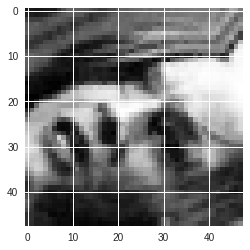

2


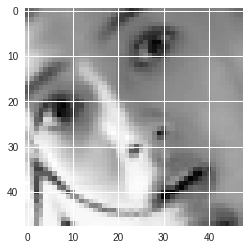

3


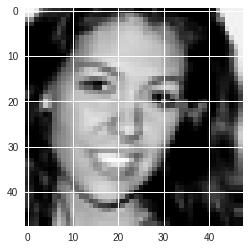

4


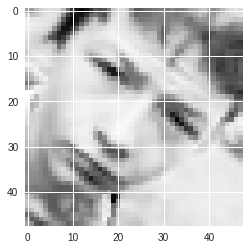

0


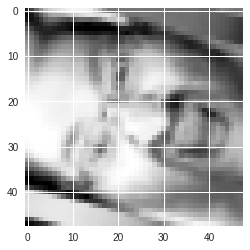

4


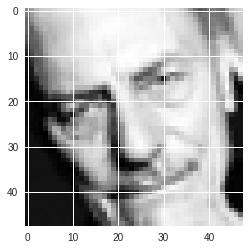

5


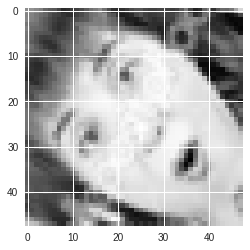

3


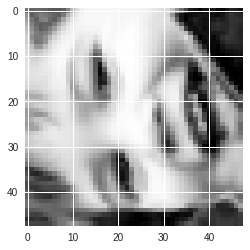

2


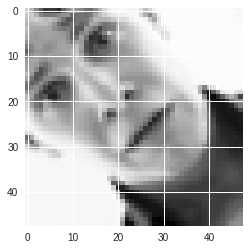

6


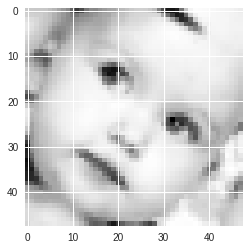

4


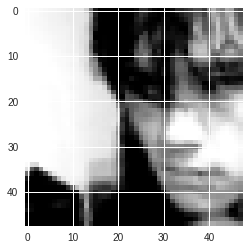

6


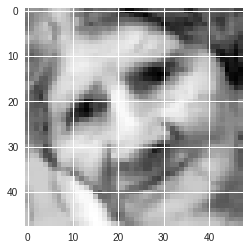

2


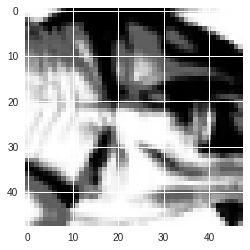

0


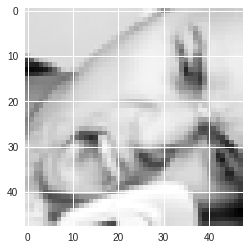

5


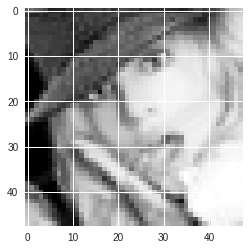

3


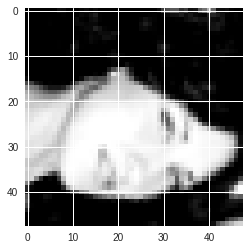

2


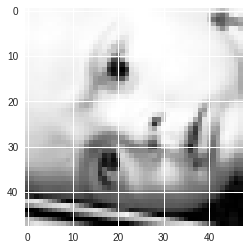

2


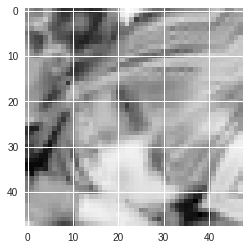

0


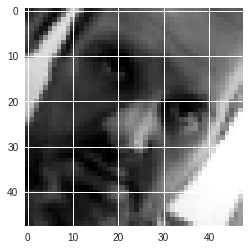

4


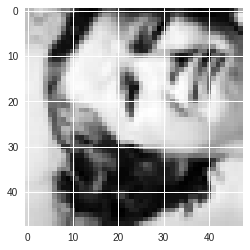

3


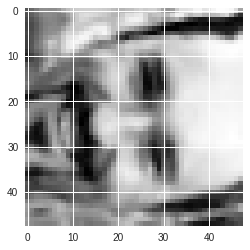

5


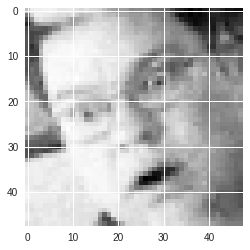

4


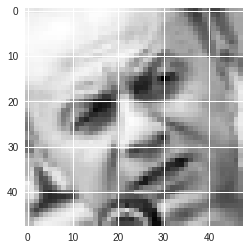

6


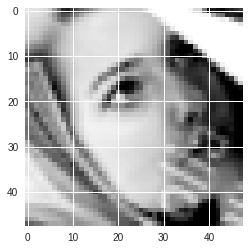

2


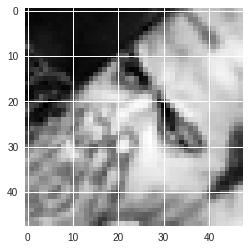

4


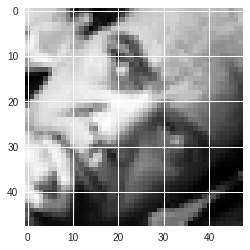

1


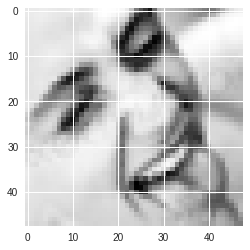

3


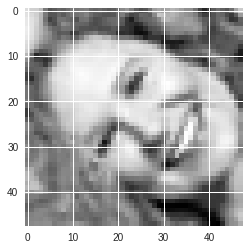

3


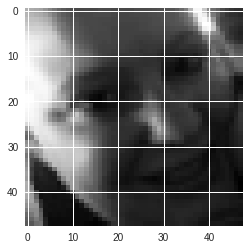

5


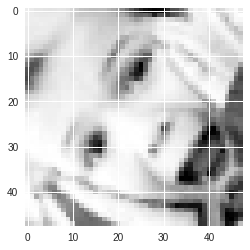

3


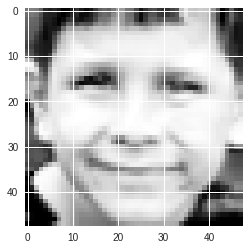

2


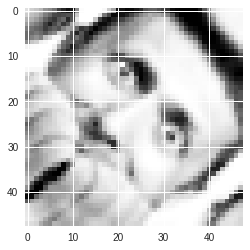

5


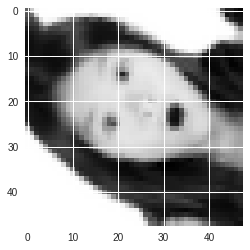

0


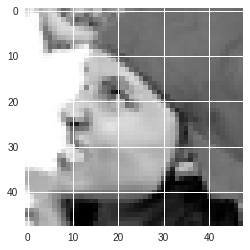

6


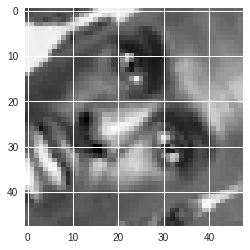

3


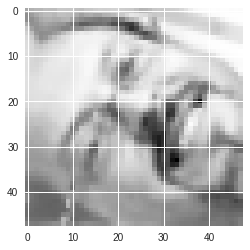

3


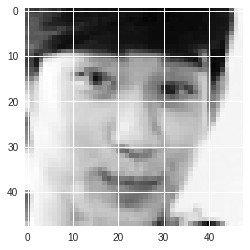

3


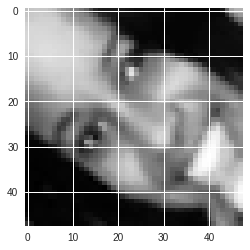

3


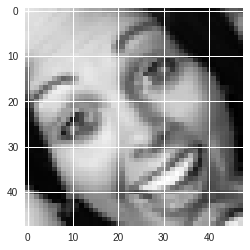

2


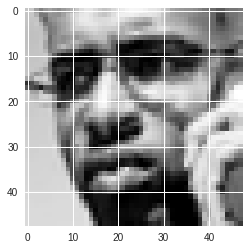

3


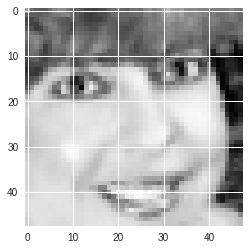

0


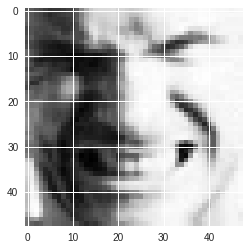

0


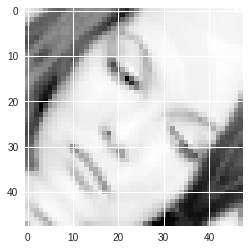

0


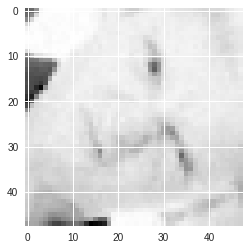

4


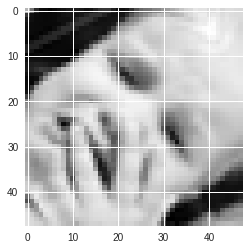

3


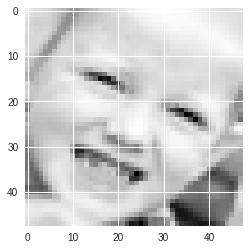

6


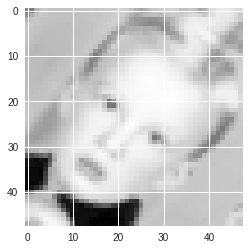

0


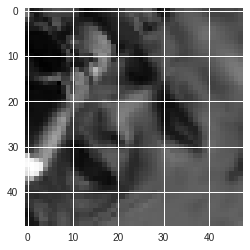

3


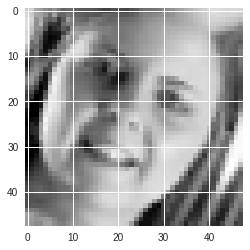

0


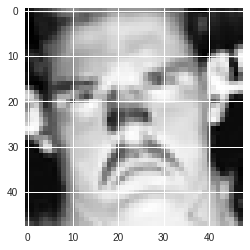

4


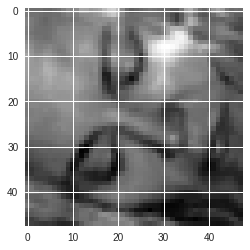

3


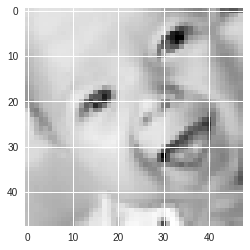

3


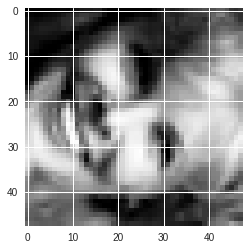

5


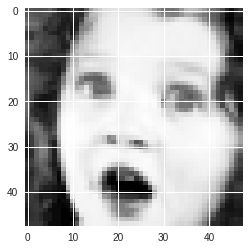

2


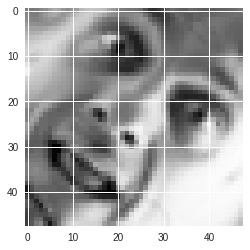

4


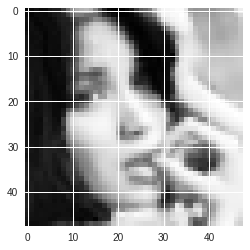

6


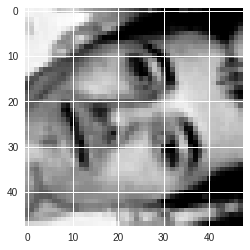

4


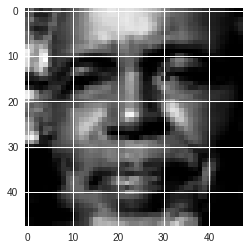

2


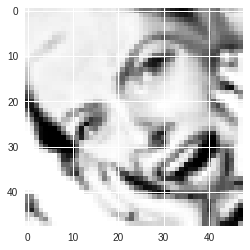

0


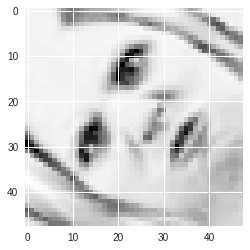

4


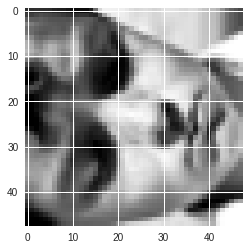

3


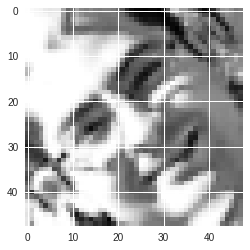

3


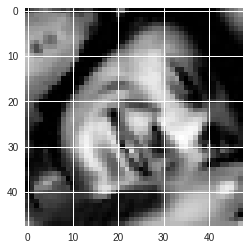

3


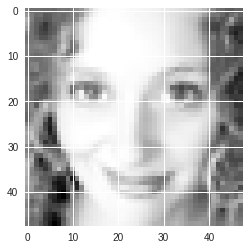

In [0]:
def visualise_batch(batch):
  for i in range(BATCH_SIZE):
    image = batch[0][i]
    image = np.squeeze(image, axis=(2,))
    conf = batch[1][i]
    print(conf.argmax())
    plt.figure()
    plt.imshow(image)
    plt.show()
    
visualise_batch(next(val_flow))

In [0]:
def ResNet18SI(input_tensor, alpha=1.0, dropout=0):
  def r(x):
    return int(round(x))
  
  batch_norm_momentum = 0.99
  relu_threshold = 6.0
  batch_norm_eps = 1e-3

  def res_block(input_tensor, filters, strides):
    output_tensor = input_tensor
    
    output_tensor = ZeroPadding2D()(output_tensor)
    output_tensor = Conv2D(kernel_size=(3, 3), filters=filters, strides=strides, use_bias=False)(output_tensor)
    output_tensor = BatchNormalization(epsilon=batch_norm_eps, momentum=batch_norm_momentum)(output_tensor)
    output_tensor = ReLU(relu_threshold)(output_tensor)

    add = output_tensor
    
    output_tensor = ZeroPadding2D()(output_tensor)
    output_tensor = Conv2D(kernel_size=(3, 3), filters=filters, strides=(1, 1), use_bias=False)(output_tensor)
    output_tensor = BatchNormalization(epsilon=batch_norm_eps, momentum=batch_norm_momentum)(output_tensor)
    output_tensor = ReLU(relu_threshold)(output_tensor)
    
    output_tensor = Add()([output_tensor, add])

    add = output_tensor
    
    output_tensor = ZeroPadding2D()(output_tensor)
    output_tensor = Conv2D(kernel_size=(3, 3), filters=filters, strides=(1, 1), use_bias=False)(output_tensor)
    output_tensor = BatchNormalization(epsilon=batch_norm_eps, momentum=batch_norm_momentum)(output_tensor)
    output_tensor = ReLU(relu_threshold)(output_tensor)
    
    output_tensor = Add()([output_tensor, add])
    
    add = output_tensor
    
    output_tensor = ZeroPadding2D()(output_tensor)
    output_tensor = Conv2D(kernel_size=(3, 3), filters=filters, strides=(1, 1), use_bias=False)(output_tensor)
    output_tensor = BatchNormalization(epsilon=batch_norm_eps, momentum=batch_norm_momentum)(output_tensor)
    output_tensor = ReLU(relu_threshold)(output_tensor)
    
    output_tensor = Add()([output_tensor, add])
    
    return output_tensor
    
  output_tensor = input_tensor
  output_tensor = res_block(output_tensor, r(64 * alpha), (1, 1))
  output_tensor = res_block(output_tensor, r(128 * alpha), (2, 2))
  output_tensor = res_block(output_tensor, r(256 * alpha), (2, 2))
  output_tensor = res_block(output_tensor, r(512 * alpha), (2, 2))
  
  output_tensor = DepthwiseConv2D(kernel_size=(output_tensor.shape.as_list()[1], output_tensor.shape.as_list()[2]), use_bias=False)(output_tensor)
  output_tensor = BatchNormalization(epsilon=batch_norm_eps, momentum=batch_norm_momentum)(output_tensor)
  output_tensor = Flatten()(output_tensor)
  
  output_tensor = Dense(r(1024 * alpha), use_bias=False)(output_tensor)
  output_tensor = BatchNormalization(epsilon=batch_norm_eps, momentum=batch_norm_momentum)(output_tensor)
  output_tensor = ReLU(relu_threshold)(output_tensor)
  
  if dropout != 0:
    output_tensor = Dropout(dropout)(output_tensor)
  
  return output_tensor

In [0]:
tf.keras.backend.clear_session()

In [0]:
input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
output_tensor = ResNet18SI(input_tensor, 0.5, 0.5)
output_tensor = Dense(EMOTION_NUM, activation='softmax')(output_tensor)
model = Model(inputs=[input_tensor], outputs=[output_tensor])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 50, 50, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 48, 32)   288         zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization_v

In [0]:
STEPS = 4000
EPOCHS = 30
VAL_STEPS = 500
INITIAL_EPOCH = 0

checkpointer = ModelCheckpoint("emotions1.h5", monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
lr_scheldure = LearningRateScheduler(lambda epoch, lr: 0.9 ** epoch * 1e-3, verbose=1)

model.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=1e-3),
                metrics=['categorical_accuracy'])

model.fit_generator(
                    train_flow,
                    steps_per_epoch=STEPS,
                    epochs=EPOCHS,
                    verbose=1,
                    use_multiprocessing=False,
                    workers=1,
                    validation_data=val_flow,
                    validation_steps=VAL_STEPS,
                    initial_epoch=INITIAL_EPOCH,
                    callbacks=[checkpointer, lr_scheldure]
                   )

Instructions for updating:
Use tf.cast instead.

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/30
500/500 [==============================] - 48s 97ms/step - loss: 1.1979 - categorical_accuracy: 0.5397

Epoch 00001: val_loss improved from inf to 1.19793, saving model to emotions1.h5
4000/4000 [==============================] - 675s 169ms/step - loss: 1.4784 - categorical_accuracy: 0.4292 - val_loss: 1.1979 - val_categorical_accuracy: 0.5397

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0009000000000000001.
Epoch 2/30
500/500 [==============================] - 49s 99ms/step - loss: 1.1609 - categorical_accuracy: 0.5610

Epoch 00002: val_loss improved from 1.19793 to 1.16091, saving model to emotions1.h5
4000/4000 [==============================] - 669s 167ms/step - loss: 1.1000 - categorical_accuracy: 0.5811 - val_loss: 1.1609 - val_categorical_accuracy: 0.5610

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0008100000000000

In [0]:
Init_PyDrive()
Upload_File("emotions1.h5", "emotions1.h5")